In [2]:
pip install scholarly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 30.9 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43550 sha256=48a78e425836357e2d31c30b7a452c4bec90025c3ec988b6a13c62711cc2ddfc
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8aadbbb17dc05f256756d8fd915
  Created wheel for free-proxy: filename=free_proxy-1.1.3-py3-none-any.whl size=6096 sha256=

Constructing citation network...

Fetching papers for Tapas K. Maiti (Author ID: 2195418997)...

Fetching papers for M. Tiwari (Author ID: 2274990155)...

Fetching papers for N. Pradhan (Author ID: 143987476)...

Network Analysis:
Number of nodes (papers): 87
Number of edges (citations): 73

Most cited paper (ID: f9af586a6b1474666458763e97aa2496ff2cdef6):
Title: Steam reforming of acetone over NiCoMgAl mixed oxide catalysts obtained from hydrotalcite precursors
Author: N. Pradhan
Year: 2020
Citations: 20

Paper with highest betweenness centrality (ID: ac9eb2e50bb38c7adc965b0e1751716461ad2b10):
Title: Selective synthesis of MIBK via acetone hydrogenation over Cu-Al mixed oxide catalysts
Author: N. Pradhan

Most influential paper (ID: f9af586a6b1474666458763e97aa2496ff2cdef6):
Title: Steam reforming of acetone over NiCoMgAl mixed oxide catalysts obtained from hydrotalcite precursors
Author: N. Pradhan

Paper with highest eigenvector centrality (ID: b665ce728b5f163bb81ffbbe5588c3c0b656c98

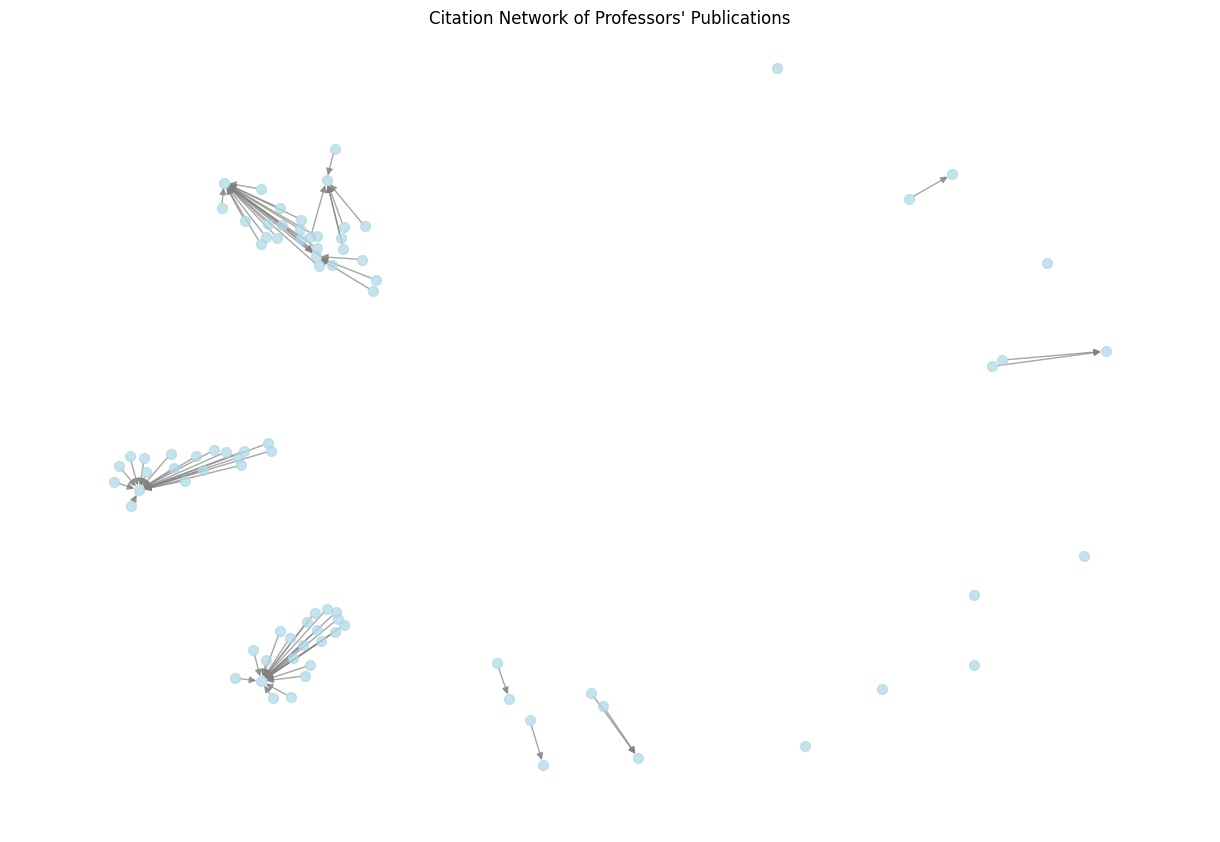

In [7]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Semantic Scholar API base URL
BASE_URL = "https://api.semanticscholar.org/graph/v1"

# Function to fetch author details by name
def fetch_author_details(author_name):
    """Fetch author details (authorId) from Semantic Scholar API."""
    response = requests.get(
        f"{BASE_URL}/author/search",
        params={'query': author_name, 'fields': 'name,authorId'}
    )
    if response.status_code == 200:
        data = response.json()
        if data.get('data'):
            return data['data'][0]  # Return the first matching author
    return None

# Function to fetch papers by author ID
def fetch_papers(author_id, years_back=5):
    """Fetch papers published by an author in the last `years_back` years."""
    current_year = 2025  # Update this to the current year
    response = requests.get(
        f"{BASE_URL}/author/{author_id}/papers",
        params={'fields': 'title,year,paperId,citationCount,references,citations'}
    )
    if response.status_code == 200:
        papers = response.json().get('data', [])
        # Filter papers from the last `years_back` years
        filtered_papers = [paper for paper in papers if paper['year'] >= (current_year - years_back)]
        return filtered_papers
    return []

# Function to fetch citation data for a paper
def fetch_citation_data(paper_id):
    """Fetch citation data for a given paper."""
    response = requests.get(
        f"{BASE_URL}/paper/{paper_id}/citations",
        params={'fields': 'title,paperId,year'}
    )
    if response.status_code == 200:
        return response.json().get('data', [])
    return []

# Function to construct the citation network
def construct_citation_network(professor_names):
    """Construct a citation network for the given professors."""
    G = nx.DiGraph()  # Directed graph for citation network
    author_papers = defaultdict(list)  # Store papers by author

    for professor in professor_names:
        # Fetch author details
        author = fetch_author_details(professor)
        if not author:
            print(f"Author not found: {professor}")
            continue

        author_id = author['authorId']
        author_name = author['name']
        print(f"\nFetching papers for {author_name} (Author ID: {author_id})...")

        # Fetch papers for the author
        papers = fetch_papers(author_id)
        for paper in papers:
            paper_id = paper['paperId']
            paper_title = paper['title']
            paper_year = paper['year']
            citation_count = paper['citationCount']

            # Add paper as a node
            G.add_node(paper_id, title=paper_title, year=paper_year, citations=citation_count, author=author_name)

            # Fetch citations for the paper
            citations = fetch_citation_data(paper_id)
            for citation in citations:
                cited_paper_id = citation['citingPaper']['paperId']
                cited_title = citation['citingPaper']['title']
                cited_year = citation['citingPaper']['year']

                # Add cited paper as a node (if not already in the graph)
                if cited_paper_id not in G:
                    G.add_node(cited_paper_id, title=cited_title, year=cited_year, citations=0, author="Unknown")

                # Add edge from cited paper to the current paper
                G.add_edge(cited_paper_id, paper_id)

    return G

# Function to analyze the citation network
def analyze_network(G):
    """Calculate graph metrics and print results."""
    print("\nNetwork Analysis:")
    print(f"Number of nodes (papers): {G.number_of_nodes()}")
    print(f"Number of edges (citations): {G.number_of_edges()}")

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    most_cited_paper = max(degree_centrality, key=degree_centrality.get)
    print(f"\nMost cited paper (ID: {most_cited_paper}):")
    print(f"Title: {G.nodes[most_cited_paper]['title']}")
    print(f"Author: {G.nodes[most_cited_paper]['author']}")
    print(f"Year: {G.nodes[most_cited_paper]['year']}")
    print(f"Citations: {G.nodes[most_cited_paper]['citations']}")

    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    bridge_paper = max(betweenness_centrality, key=betweenness_centrality.get)
    print(f"\nPaper with highest betweenness centrality (ID: {bridge_paper}):")
    print(f"Title: {G.nodes[bridge_paper]['title']}")
    print(f"Author: {G.nodes[bridge_paper]['author']}")

    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    most_influential_paper = max(closeness_centrality, key=closeness_centrality.get)
    print(f"\nMost influential paper (ID: {most_influential_paper}):")
    print(f"Title: {G.nodes[most_influential_paper]['title']}")
    print(f"Author: {G.nodes[most_influential_paper]['author']}")

    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    most_connected_paper = max(eigenvector_centrality, key=eigenvector_centrality.get)
    print(f"\nPaper with highest eigenvector centrality (ID: {most_connected_paper}):")
    print(f"Title: {G.nodes[most_connected_paper]['title']}")
    print(f"Author: {G.nodes[most_connected_paper]['author']}")

    # Print all papers and their details
    # print("\nDetails of all papers in the network:")
    # for paper_id, data in G.nodes(data=True):
    #     print(f"\nPaper ID: {paper_id}")
    #     print(f"Title: {data['title']}")
    #     print(f"Author: {data['author']}")
    #     print(f"Year: {data['year']}")
    #     print(f"Citations: {data['citations']}")

# Function to visualize the citation network
def visualize_network(G):
    """Visualize the citation network."""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7)
    plt.title("Citation Network of Professors' Publications")
    plt.show()

# Main function
def main():
    # List of professors
    professor_names = ["Tapas Kumar Maiti", "Manoj Kumar Tiwari", "Narayan C. Pradhan"]

    # Construct the citation network
    print("Constructing citation network...")
    citation_network = construct_citation_network(professor_names)

    # Analyze the network
    analyze_network(citation_network)

    # Visualize the network
    print("\nVisualizing the citation network...")
    visualize_network(citation_network)

# Run the program
if __name__ == "__main__":
    main()

Constructing citation network...

Fetching papers for A. Isloor (Author ID: 152288559)...

Fetching papers for D. K. Bhat (Author ID: 2256843057)...
Author not found: Dr. Jeyaraj Pitchaimani

Network Analysis:
Number of nodes (papers): 390
Number of edges (citations): 401

Most cited paper (ID: d88a3e9c627a6e6159c3e8413b27cb7dd6ad3fa2):
Title: Vanadium-Doped SrTiO3 Nanocubes: Insight into role of vanadium in improving the photocatalytic activity
Author: D. K. Bhat
Year: 2020
Citations: 87

Paper with highest betweenness centrality (ID: 04248bbb773cca5e322064f676efd11dd1375ee0):
Title: Improved hydrophilic and antifouling performance of nanocomposite ultrafiltration zwitterionic polyphenylsulfone membrane for protein rejection applications
Author: A. Isloor

Most influential paper (ID: d88a3e9c627a6e6159c3e8413b27cb7dd6ad3fa2):
Title: Vanadium-Doped SrTiO3 Nanocubes: Insight into role of vanadium in improving the photocatalytic activity
Author: D. K. Bhat

Paper with highest eigenvector

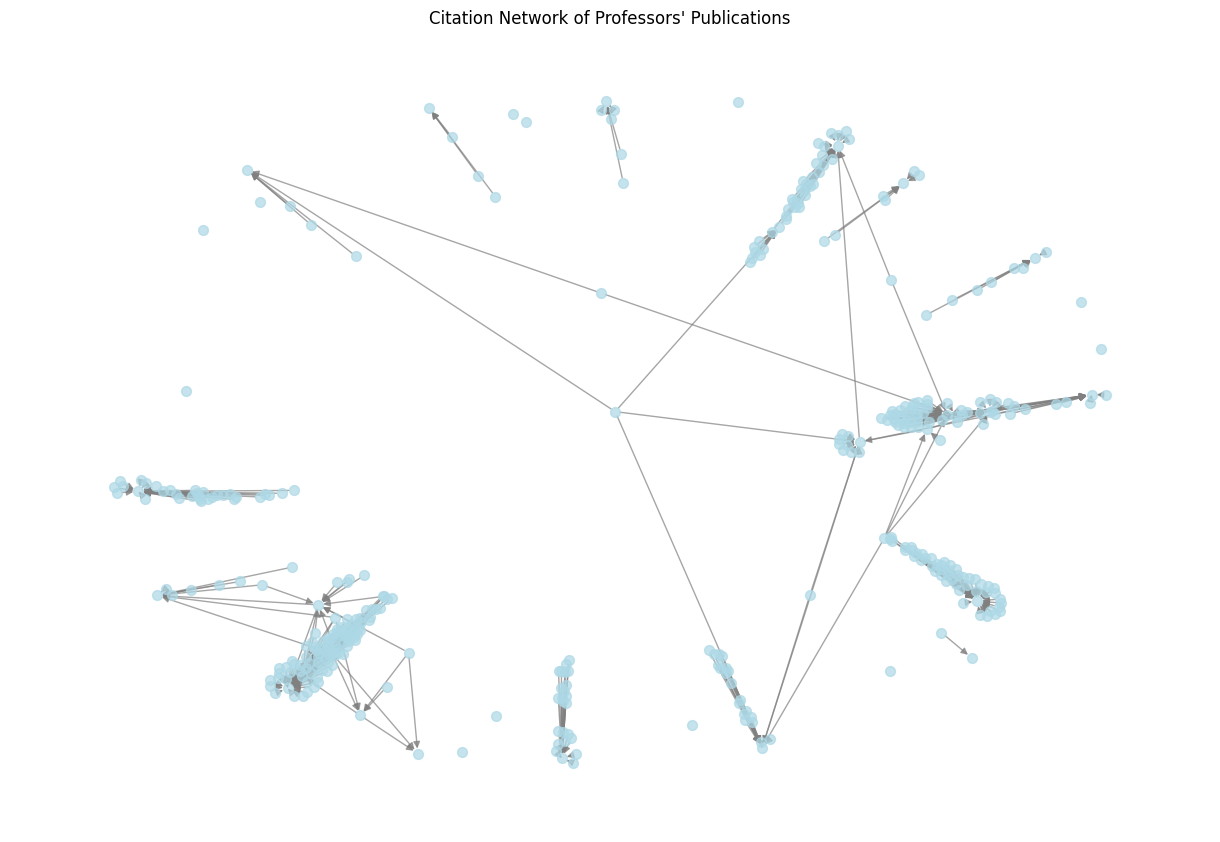

In [9]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Semantic Scholar API base URL
BASE_URL = "https://api.semanticscholar.org/graph/v1"

# Function to fetch author details by name
def fetch_author_details(author_name):
    """Fetch author details (authorId) from Semantic Scholar API."""
    response = requests.get(
        f"{BASE_URL}/author/search",
        params={'query': author_name, 'fields': 'name,authorId'}
    )
    if response.status_code == 200:
        data = response.json()
        if data.get('data'):
            return data['data'][0]  # Return the first matching author
    return None

# Function to fetch papers by author ID
def fetch_papers(author_id, years_back=5):
    """Fetch papers published by an author in the last `years_back` years."""
    current_year = 2025  # Update this to the current year
    response = requests.get(
        f"{BASE_URL}/author/{author_id}/papers",
        params={'fields': 'title,year,paperId,citationCount,references,citations'}
    )
    if response.status_code == 200:
        papers = response.json().get('data', [])
        # Filter papers from the last `years_back` years
        filtered_papers = [paper for paper in papers if paper['year'] >= (current_year - years_back)]
        return filtered_papers
    return []

# Function to fetch citation data for a paper
def fetch_citation_data(paper_id):
    """Fetch citation data for a given paper."""
    response = requests.get(
        f"{BASE_URL}/paper/{paper_id}/citations",
        params={'fields': 'title,paperId,year'}
    )
    if response.status_code == 200:
        return response.json().get('data', [])
    return []

# Function to construct the citation network
def construct_citation_network(professor_names):
    """Construct a citation network for the given professors."""
    G = nx.DiGraph()  # Directed graph for citation network
    author_papers = defaultdict(list)  # Store papers by author

    for professor in professor_names:
        # Fetch author details
        author = fetch_author_details(professor)
        if not author:
            print(f"Author not found: {professor}")
            continue

        author_id = author['authorId']
        author_name = author['name']
        print(f"\nFetching papers for {author_name} (Author ID: {author_id})...")

        # Fetch papers for the author
        papers = fetch_papers(author_id)
        for paper in papers:
            paper_id = paper['paperId']
            paper_title = paper['title']
            paper_year = paper['year']
            citation_count = paper['citationCount']

            # Add paper as a node
            G.add_node(paper_id, title=paper_title, year=paper_year, citations=citation_count, author=author_name)

            # Fetch citations for the paper
            citations = fetch_citation_data(paper_id)
            for citation in citations:
                cited_paper_id = citation['citingPaper']['paperId']
                cited_title = citation['citingPaper']['title']
                cited_year = citation['citingPaper']['year']

                # Add cited paper as a node (if not already in the graph)
                if cited_paper_id not in G:
                    G.add_node(cited_paper_id, title=cited_title, year=cited_year, citations=0, author="Unknown")

                # Add edge from cited paper to the current paper
                G.add_edge(cited_paper_id, paper_id)

    return G

# Function to analyze the citation network
def analyze_network(G):
    """Calculate graph metrics and print results."""
    print("\nNetwork Analysis:")
    print(f"Number of nodes (papers): {G.number_of_nodes()}")
    print(f"Number of edges (citations): {G.number_of_edges()}")

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    most_cited_paper = max(degree_centrality, key=degree_centrality.get)
    print(f"\nMost cited paper (ID: {most_cited_paper}):")
    print(f"Title: {G.nodes[most_cited_paper]['title']}")
    print(f"Author: {G.nodes[most_cited_paper]['author']}")
    print(f"Year: {G.nodes[most_cited_paper]['year']}")
    print(f"Citations: {G.nodes[most_cited_paper]['citations']}")

    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    bridge_paper = max(betweenness_centrality, key=betweenness_centrality.get)
    print(f"\nPaper with highest betweenness centrality (ID: {bridge_paper}):")
    print(f"Title: {G.nodes[bridge_paper]['title']}")
    print(f"Author: {G.nodes[bridge_paper]['author']}")

    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    most_influential_paper = max(closeness_centrality, key=closeness_centrality.get)
    print(f"\nMost influential paper (ID: {most_influential_paper}):")
    print(f"Title: {G.nodes[most_influential_paper]['title']}")
    print(f"Author: {G.nodes[most_influential_paper]['author']}")

    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    most_connected_paper = max(eigenvector_centrality, key=eigenvector_centrality.get)
    print(f"\nPaper with highest eigenvector centrality (ID: {most_connected_paper}):")
    print(f"Title: {G.nodes[most_connected_paper]['title']}")
    print(f"Author: {G.nodes[most_connected_paper]['author']}")

    # Print all papers and their details
    # print("\nDetails of all papers in the network:")
    # for paper_id, data in G.nodes(data=True):
    #     print(f"\nPaper ID: {paper_id}")
    #     print(f"Title: {data['title']}")
    #     print(f"Author: {data['author']}")
    #     print(f"Year: {data['year']}")
    #     print(f"Citations: {data['citations']}")

# Function to visualize the citation network
def visualize_network(G):
    """Visualize the citation network."""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7)
    plt.title("Citation Network of Professors' Publications")
    plt.show()

# Main function
def main():
    # List of professors
    professor_names = ["Arun M. Isloor", "Denthaje Krishna Bhat", "Dr. Jeyaraj Pitchaimani"]

    # Construct the citation network
    print("Constructing citation network...")
    citation_network = construct_citation_network(professor_names)

    # Analyze the network
    analyze_network(citation_network)

    # Visualize the network
    print("\nVisualizing the citation network...")
    visualize_network(citation_network)

# Run the program
if __name__ == "__main__":
    main()

Constructing citation network...

Fetching papers for Dr Pradip M. Jawandhiya (Author ID: 9360089)...

Network Analysis:
Number of nodes (papers): 155
Number of edges (citations): 144

Most cited paper (ID: 9c70f24daf3ebffa89d4540601d1339d9ea2e116):
Title: A Survey of Mobile Ad Hoc Network Attacks
Author: Dr Pradip M. Jawandhiya
Year: 2019
Citations: 161

Paper with highest betweenness centrality (ID: 4ebd1d1a7b94512ccf891eaf8bfe91062584666d):
Title: Review on single-path multi-path routing protocol in manet: A study
Author: Dr Pradip M. Jawandhiya

Most influential paper (ID: 9c70f24daf3ebffa89d4540601d1339d9ea2e116):
Title: A Survey of Mobile Ad Hoc Network Attacks
Author: Dr Pradip M. Jawandhiya

Paper with highest eigenvector centrality (ID: 960846921097f0867b940224d6518d81476f1eae):
Title: Security Aware Routing Protocols for Mobile Ad hoc Networks
Author: Dr Pradip M. Jawandhiya

Visualizing the citation network...


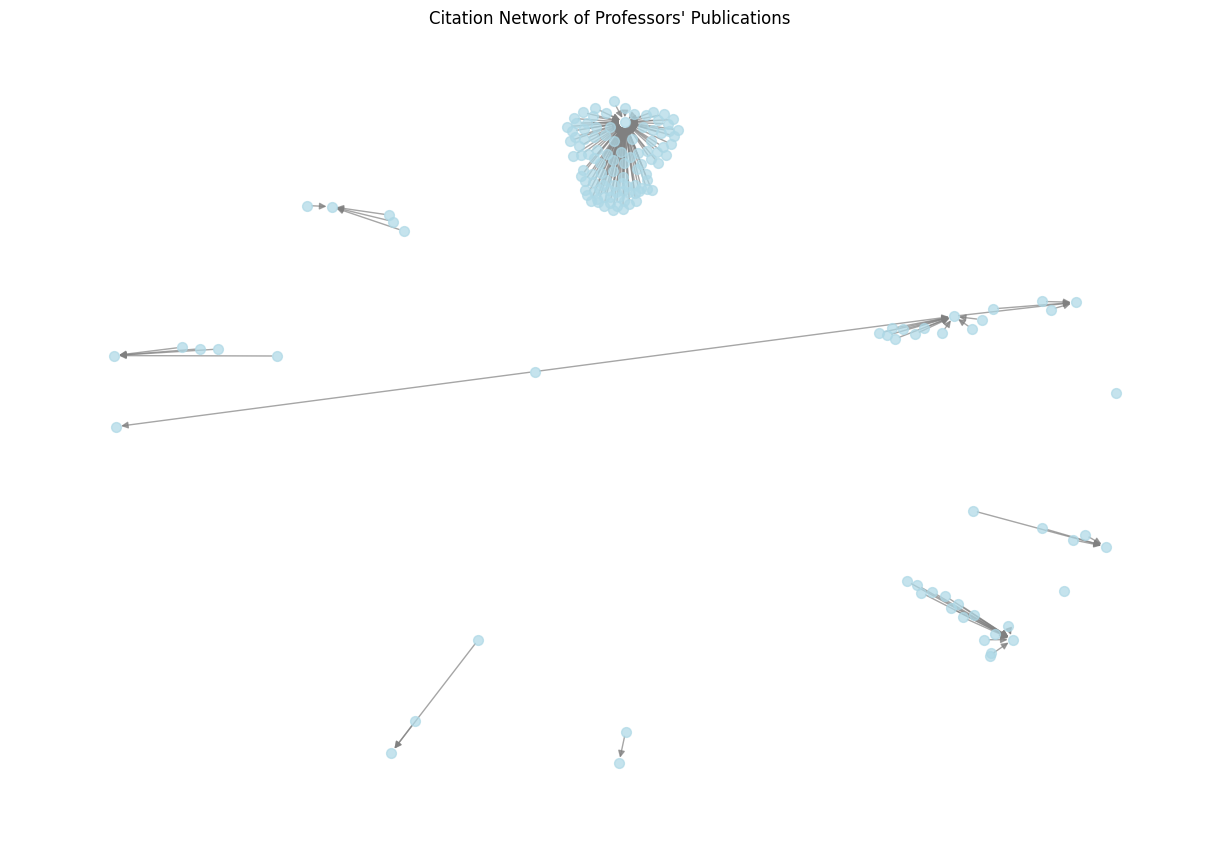

In [11]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Semantic Scholar API base URL
BASE_URL = "https://api.semanticscholar.org/graph/v1"

# Function to fetch author details by name
def fetch_author_details(author_name):
    """Fetch author details (authorId) from Semantic Scholar API."""
    response = requests.get(
        f"{BASE_URL}/author/search",
        params={'query': author_name, 'fields': 'name,authorId'}
    )
    if response.status_code == 200:
        data = response.json()
        if data.get('data'):
            return data['data'][0]  # Return the first matching author
    return None

# Function to fetch papers by author ID
def fetch_papers(author_id, years_back=3):
    """Fetch papers published by an author in the last `years_back` years."""
    current_year = 2025  # Update this to the current year
    response = requests.get(
        f"{BASE_URL}/author/{author_id}/papers",
        params={'fields': 'title,year,paperId,citationCount,references,citations'}
    )
    if response.status_code == 200:
        papers = response.json().get('data', [])
        return papers
    return []

# Function to fetch citation data for a paper
def fetch_citation_data(paper_id):
    """Fetch citation data for a given paper."""
    response = requests.get(
        f"{BASE_URL}/paper/{paper_id}/citations",
        params={'fields': 'title,paperId,year'}
    )
    if response.status_code == 200:
        return response.json().get('data', [])
    return []

# Function to construct the citation network
def construct_citation_network(professor_names):
    """Construct a citation network for the given professors."""
    G = nx.DiGraph()  # Directed graph for citation network
    author_papers = defaultdict(list)  # Store papers by author

    for professor in professor_names:
        # Fetch author details
        author = fetch_author_details(professor)
        if not author:
            print(f"Author not found: {professor}")
            continue

        author_id = author['authorId']
        author_name = author['name']
        print(f"\nFetching papers for {author_name} (Author ID: {author_id})...")

        # Fetch papers for the author
        papers = fetch_papers(author_id)
        for paper in papers:
            paper_id = paper['paperId']
            paper_title = paper['title']
            paper_year = paper['year']
            citation_count = paper['citationCount']

            # Add paper as a node
            G.add_node(paper_id, title=paper_title, year=paper_year, citations=citation_count, author=author_name)

            # Fetch citations for the paper
            citations = fetch_citation_data(paper_id)
            for citation in citations:
                cited_paper_id = citation['citingPaper']['paperId']
                cited_title = citation['citingPaper']['title']
                cited_year = citation['citingPaper']['year']

                # Add cited paper as a node (if not already in the graph)
                if cited_paper_id not in G:
                    G.add_node(cited_paper_id, title=cited_title, year=cited_year, citations=0, author="Unknown")

                # Add edge from cited paper to the current paper
                G.add_edge(cited_paper_id, paper_id)

    return G

# Function to analyze the citation network
def analyze_network(G):
    """Calculate graph metrics and print results."""
    print("\nNetwork Analysis:")
    print(f"Number of nodes (papers): {G.number_of_nodes()}")
    print(f"Number of edges (citations): {G.number_of_edges()}")

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    most_cited_paper = max(degree_centrality, key=degree_centrality.get)
    print(f"\nMost cited paper (ID: {most_cited_paper}):")
    print(f"Title: {G.nodes[most_cited_paper]['title']}")
    print(f"Author: {G.nodes[most_cited_paper]['author']}")
    print(f"Year: {G.nodes[most_cited_paper]['year']}")
    print(f"Citations: {G.nodes[most_cited_paper]['citations']}")

    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    bridge_paper = max(betweenness_centrality, key=betweenness_centrality.get)
    print(f"\nPaper with highest betweenness centrality (ID: {bridge_paper}):")
    print(f"Title: {G.nodes[bridge_paper]['title']}")
    print(f"Author: {G.nodes[bridge_paper]['author']}")

    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    most_influential_paper = max(closeness_centrality, key=closeness_centrality.get)
    print(f"\nMost influential paper (ID: {most_influential_paper}):")
    print(f"Title: {G.nodes[most_influential_paper]['title']}")
    print(f"Author: {G.nodes[most_influential_paper]['author']}")

    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    most_connected_paper = max(eigenvector_centrality, key=eigenvector_centrality.get)
    print(f"\nPaper with highest eigenvector centrality (ID: {most_connected_paper}):")
    print(f"Title: {G.nodes[most_connected_paper]['title']}")
    print(f"Author: {G.nodes[most_connected_paper]['author']}")

    # Print all papers and their details
    # print("\nDetails of all papers in the network:")
    # for paper_id, data in G.nodes(data=True):
    #     print(f"\nPaper ID: {paper_id}")
    #     print(f"Title: {data['title']}")
    #     print(f"Author: {data['author']}")
    #     print(f"Year: {data['year']}")
    #     print(f"Citations: {data['citations']}")

# Function to visualize the citation network
def visualize_network(G):
    """Visualize the citation network."""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7)
    plt.title("Citation Network of Professors' Publications")
    plt.show()

# Main function
def main():
    # List of professors
    professor_names = ["Dr. Pradip Jawandhiya"]

    # Construct the citation network
    print("Constructing citation network...")
    citation_network = construct_citation_network(professor_names)

    # Analyze the network
    analyze_network(citation_network)

    # Visualize the network
    print("\nVisualizing the citation network...")
    visualize_network(citation_network)

# Run the program
if __name__ == "__main__":
    main()